In [3]:
import math
import qiskit
import cirq
import mitiq
from bqskit import Circuit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit_ibm_provider import IBMProvider
import matplotlib.pyplot as plt
import os

In [4]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_amod15(qc,qr,cr,a):
    if a == 2:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
    elif a == 7:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 8:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
    elif a == 11: # this is included for completeness
        qc.cswap(qr[4],qr[2],qr[0])
        qc.cswap(qr[4],qr[3],qr[1])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 13:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])

In [5]:
def circuit_aperiod15(qc,qr,cr,a):
    if a == 11:
        circuit_11period15(qc,qr,cr)
        return
    
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])

    

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled unitary
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    #   feed forward
    qc.p(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    

    # Apply a mod 15
    qc.h(qr[4])
    #   controlled unitary.
    circuit_amod15(qc,qr,cr,a)
    #   feed forward
    qc.p(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.p(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.p(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])


In [6]:
def circuit_11period15(qc,qr,cr):
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    #   feed forward
    qc.p(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    
    # Apply 11 mod 15
    qc.h(qr[4])
    #   controlled unitary.
    qc.cx(qr[4],qr[3])
    qc.cx(qr[4],qr[1])
    #   feed forward
    qc.p(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.p(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.p(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

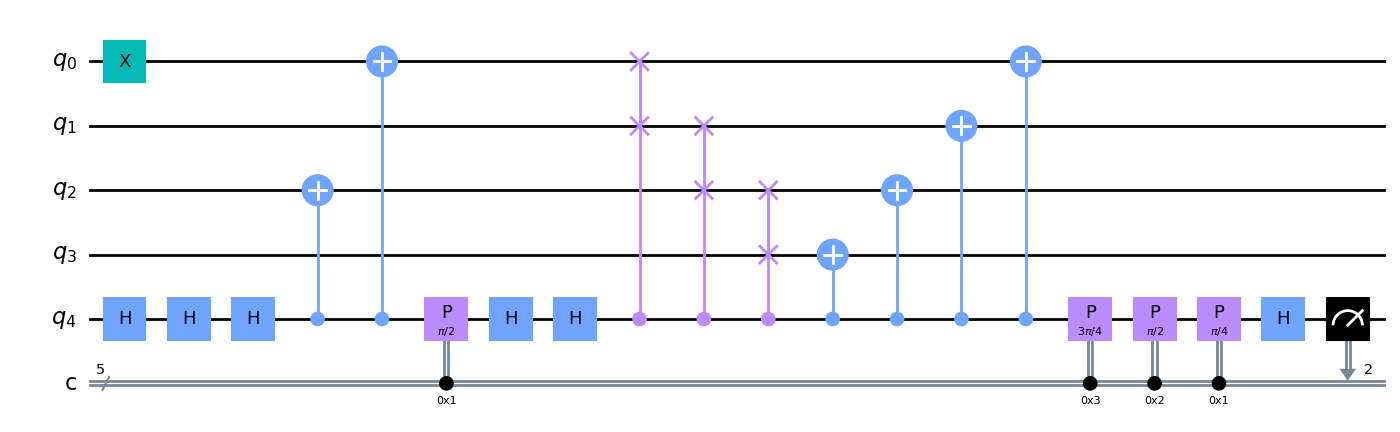

In [7]:
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,7)
shor.draw(output='mpl')

In [8]:
from qiskit.test.ibmq_mock import mock_get_backend
from mitiq import zne
from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise

In [9]:
# Default to a simulator.
backend = Aer.get_backend("qasm_simulator")

def ibmq_executor(circuit: qiskit.QuantumCircuit, shots: int = 2048) -> float:
    
    # Simulate the circuit with noise
    noise_model = initialized_depolarizing_noise(noise_level=0.02)
    job = qiskit.execute(
        experiments=circuit,  # Use the provided circuit
        backend=Aer.get_backend("qasm_simulator"),       # Use the specified backend
        noise_model=noise_model,
        basis_gates=noise_model.basis_gates,
        optimization_level=1,  # Important to preserve folded gates.
        shots=shots,
    )

    # Convert from raw measurement counts to the expectation value
    counts = job.result().get_counts()
    if counts.get("11") is None:
        expectation_value = 0.
    else:
        expectation_value = counts.get("11") / shots
    return expectation_value

In [10]:
import cirq
import math

def circuit_amod15(qc, qr, cr, a):
    if a == 2:
        qc.append(cirq.CSWAP(qr[4], qr[3], qr[2]))
        qc.append(cirq.CSWAP(qr[4], qr[2], qr[1]))
        qc.append(cirq.CSWAP(qr[4], qr[1], qr[0]))
    elif a == 7:
        qc.append(cirq.CSWAP(qr[4], qr[1], qr[0]))
        qc.append(cirq.CSWAP(qr[4], qr[2], qr[1]))
        qc.append(cirq.CSWAP(qr[4], qr[3], qr[2]))
        qc.append(cirq.CX(qr[4], qr[3]))
        qc.append(cirq.CX(qr[4], qr[2]))
        qc.append(cirq.CX(qr[4], qr[1]))
        qc.append(cirq.CX(qr[4], qr[0]))
    elif a == 8:
        qc.append(cirq.CSWAP(qr[4], qr[1], qr[0]))
        qc.append(cirq.CSWAP(qr[4], qr[2], qr[1]))
        qc.append(cirq.CSWAP(qr[4], qr[3], qr[2]))
    elif a == 11:
        qc.append(cirq.CSWAP(qr[4], qr[2], qr[0]))
        qc.append(cirq.CSWAP(qr[4], qr[3], qr[1]))
        qc.append(cirq.CX(qr[4], qr[3]))
        qc.append(cirq.CX(qr[4], qr[2]))
        qc.append(cirq.CX(qr[4], qr[1]))
        qc.append(cirq.CX(qr[4], qr[0]))
    elif a == 13:
        qc.append(cirq.CSWAP(qr[4], qr[3], qr[2]))
        qc.append(cirq.CSWAP(qr[4], qr[2], qr[1]))
        qc.append(cirq.CSWAP(qr[4], qr[1], qr[0]))
        qc.append(cirq.CX(qr[4], qr[3]))
        qc.append(cirq.CX(qr[4], qr[2]))
        qc.append(cirq.CX(qr[4], qr[1]))
        qc.append(cirq.CX(qr[4], qr[0]))

def circuit_aperiod_15(qc, qr, cr, a):
    if a == 11:
        circuit_11period_n(qc, qr, cr)
        return

    # Initialize q[0] to |1>
    qc.append(cirq.X(qr[0]))

    # Apply a**4 mod n
    qc.append([cirq.H(qr[4]), cirq.H(qr[4]), cirq.H(qr[4])])
    
    
    # Apply a**2 mod n
    qc.append(cirq.H(qr[4]))
    qc.append(cirq.CNOT(qr[4], qr[2]))
    qc.append(cirq.CNOT(qr[4], qr[0]))
    qc.append(cirq.ControlledGate(cirq.PhasedXPowGate(phase_exponent=0.5*math.pi)).on(qr[4], cr[1]))
    qc.append([cirq.H(qr[4]), cirq.H(qr[4])])
    
    
    # Apply a mod n
    qc.append(cirq.H(qr[4]))
    qc.append(cirq.CNOT(qr[4], qr[3]))
    qc.append(cirq.CNOT(qr[4], qr[2]))
    qc.append(cirq.CNOT(qr[4], qr[1]))
    qc.append(cirq.CNOT(qr[4], qr[0]))
    qc.append(cirq.ControlledGate(cirq.PhasedXPowGate(phase_exponent=0.75*math.pi)).on(cr[2], qr[4]))
    qc.append(cirq.ControlledGate(cirq.PhasedXPowGate(phase_exponent=0.5*math.pi)).on(cr[1], qr[4]))
    qc.append(cirq.ControlledGate(cirq.PhasedXPowGate(phase_exponent=0.25*math.pi)).on(cr[0], qr[4]))
    qc.append([cirq.H(qr[4]), cirq.H(qr[4])])
    
    qc.append(cirq.measure(qr[4], cr[2]))


    
# Example usage
qubits = cirq.LineQubit.range(5)
classical_bits = cirq.LineQubit.range(3)
shor_circuit = cirq.Circuit()
circuit_aperiod_15(shor_circuit, qubits, classical_bits, 7)
print(shor_circuit)


0: ───X───────────────────X─────────────────────────────────────────X──────────────────────────────@────────────────────────
                          │                                         │                              │
1: ───────────────────────┼───PhX(-0.429)───────────────────────X───┼────────────────@─────────────┼────────────────────────
                          │   │                                 │   │                │             │
2: ───────────────────X───┼───┼─────────────────────────────X───┼───┼───@────────────┼─────────────┼────────────────────M───
                      │   │   │                             │   │   │   │            │             │                    │
3: ───────────────────┼───┼───┼─────────────────────────X───┼───┼───┼───┼────────────┼─────────────┼────────────────────┼───
                      │   │   │                         │   │   │   │   │            │             │                    │
4: ───H───H───H───H───@───@───@─────────────H───H───H─

In [14]:
job = qiskit.execute(
        experiments=qiskit_circuit,  # Use the provided circuit
        backend=Aer.get_backend("qasm_simulator"),       # Use the specified backend
        shots=1024,
    )

    # Convert from raw measurement counts to the expectation value
counts = job.result().get_counts()
print(counts)

{'11': 521, '01': 503}


In [15]:
# Vérifier si la clé "1" est présente dans le dictionnaire
if "11" in counts:
    # Calculer l'expectation value en fonction du nombre de mesures de l'état excitée
    expectation_value = counts["11"] / 1024
else:
    # Si la clé "1" n'est pas présente, l'expectation value est égal à zéro
    expectation_value = 0.0
print(expectation_value)

0.5087890625


In [13]:
from mitiq.interface.mitiq_qiskit.conversions import to_qiskit
# Convertissez le circuit Cirq en circuit Qiskit
qiskit_circuit = to_qiskit(shor_circuit)

In [34]:
unmitigated = ibmq_executor(qiskit_circuit)
mitigated = zne.execute_with_zne(qiskit_circuit, ibmq_executor)
print(f"Unmitigated result {unmitigated:.3f}")
print(f"Mitigated result {mitigated:.3f}")

Unmitigated result 0.373
Mitigated result 0.430


In [26]:
qasm_code = cirq.qasm(shor_circuit)
with open('tmp1.qasm', 'w') as f:
    f.write(qasm_code[31:])

In [18]:
import cirq
from mitiq import zne, benchmarks


def execute(circuit, noise_level=0.005):
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit
    with depolarizing noise."""
    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))
    return (
        cirq.DensityMatrixSimulator()
        .simulate(noisy_circuit)
        .final_density_matrix[0, 0]
        .real
    )

In [23]:
print(shor_circuit)

0: ───X───────────────────X─────────────────────────────────────────X──────────────────────────────@────────────────────────
                          │                                         │                              │
1: ───────────────────────┼───PhX(-0.429)───────────────────────X───┼────────────────@─────────────┼────────────────────────
                          │   │                                 │   │                │             │
2: ───────────────────X───┼───┼─────────────────────────────X───┼───┼───@────────────┼─────────────┼────────────────────M───
                      │   │   │                             │   │   │   │            │             │                    │
3: ───────────────────┼───┼───┼─────────────────────────X───┼───┼───┼───┼────────────┼─────────────┼────────────────────┼───
                      │   │   │                         │   │   │   │   │            │             │                    │
4: ───H───H───H───H───@───@───@─────────────H───H───H─

In [28]:
import cirq
import numpy as np
from mitiq import MeasurementResult, Calibrator

In [33]:
from mitiq.zne.inference import LinearFactory

linear_factory = LinearFactory ( scale_factors =[1.0 , 3.0 , 5.0])

In [35]:
from mitiq.benchmarks import generate_rb_circuits
from mitiq.zne import execute_with_zne
from mitiq.zne.scaling import (
    fold_gates_at_random,
    fold_global,
    fold_all
)
from mitiq.zne.inference import LinearFactory, RichardsonFactory
from mitiq import (
    Calibrator,
    Settings,
    execute_with_mitigation,
    MeasurementResult,
)

from qiskit.providers.fake_provider import FakeJakarta  # Fake (simulated) QPU

In [38]:
print(len(qiskit_circuit))
print(qiskit_circuit)


42
            ┌───┐                           ┌───┐                            »
 q_0: ──────┤ X ├───────────────────────────┤ X ├────────────────────────────»
      ┌─────┴───┴──────┐                    └─┬─┘     ┌───┐┌────────────────┐»
 q_1: ┤ U3(0,4.49,π/2) ├──────────────────────┼───────┤ X ├┤ U3(3π/2,π,π/2) ├»
      └────────────────┘               ┌───┐  │       └─┬─┘└────────────────┘»
 q_2: ─────────────────────────────────┤ X ├──┼─────────┼────────────────────»
                                       └─┬─┘  │         │                    »
 q_3: ───────────────────────────────────┼────┼─────────┼────────────────────»
            ┌───┐       ┌───┐┌───┐┌───┐  │    │  ┌───┐  │                    »
 q_4: ──────┤ H ├───────┤ H ├┤ H ├┤ H ├──■────■──┤ S ├──■────────────────────»
            └───┘       └───┘└───┘└───┘          └───┘                       »
m0: 2/═══════════════════════════════════════════════════════════════════════»
                                                 

In [74]:
# Obtenez la profondeur du circuit
circuit_depth = qiskit_circuit.depth()

# Affichez la profondeur
print("Profondeur du circuit :", circuit_depth)


Profondeur du circuit : 35


In [70]:
def execute_circuit(circuit):
    """Execute the input circuit and return the expectation value of |00..0><00..0|"""
    noisy_backend = FakeJakarta()
    noisy_result = noisy_backend.run(circuit, shots=512).result()
    noisy_counts = noisy_result.get_counts(circuit)
    noisy_expectation_value = noisy_counts["01"] / 512
    return noisy_expectation_value

In [92]:
mitigated = execute_with_zne(qiskit_circuit, execute_circuit, factory=LinearFactory([1, 3, 5]))
unmitigated = execute_circuit(qiskit_circuit)
ideal = 1 #property of RB circuits

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.50000
mitigated = 	 	 0.53516


In [93]:
mitigated = execute_with_zne(qiskit_circuit, execute_circuit, factory=LinearFactory([1, 3, 5]))
unmitigated = execute_circuit(qiskit_circuit)
ideal = 1 #property of RB circuits

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.48828
mitigated = 	 	 0.50163


In [72]:
def execute_calibration(qiskit_circuit):
    """Execute the input circuits and return the measurement results."""
    noisy_backend = FakeJakarta()
    noisy_result = noisy_backend.run(qiskit_circuit, shots=1024).result()
    noisy_counts = noisy_result.get_counts(qiskit_circuit)
    noisy_counts = { k.replace(" ",""):v for k, v in noisy_counts.items()}
    measurements = MeasurementResult.from_counts(noisy_counts)
    return measurements

In [77]:
RBSettings = Settings(
    benchmarks=[
        {
            "circuit_type": "rb",
            "num_qubits": 2,
            "circuit_depth": int(circuit_depth / 2),
        },
    ],
    strategies=[
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": RichardsonFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": RichardsonFactory([1.0, 3.0, 5.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": LinearFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": LinearFactory([1.0, 3.0, 5.0]),
        },

        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": RichardsonFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": RichardsonFactory([1.0, 3.0, 5.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": LinearFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": LinearFactory([1.0, 3.0, 5.0]),
        },

        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": RichardsonFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": RichardsonFactory([1.0, 3.0, 5.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": LinearFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": LinearFactory([1.0, 3.0, 5.0]),
        },

    ],
)

In [78]:
cal = Calibrator(execute_calibration, frontend="qiskit", settings=RBSettings)
cal.run(log="flat")

| performance | circuit | method | extrapolation | scale factors | scale_method         |
| ----------- | ------- | ------ | ------------- | ------------- | -------------------- |
|     ❌      |   rb    |  ZNE   | Richardson    | 1.0, 2.0, 3.0 | fold_global          |
|     ✅      |   rb    |  ZNE   | Richardson    | 1.0, 3.0, 5.0 | fold_global          |
|     ✅      |   rb    |  ZNE   | Linear        | 1.0, 2.0, 3.0 | fold_global          |
|     ❌      |   rb    |  ZNE   | Linear        | 1.0, 3.0, 5.0 | fold_global          |
|     ✅      |   rb    |  ZNE   | Richardson    | 1.0, 2.0, 3.0 | fold_gates_at_random |
|     ✅      |   rb    |  ZNE   | Richardson    | 1.0, 3.0, 5.0 | fold_gates_at_random |
|     ✅      |   rb    |  ZNE   | Linear        | 1.0, 2.0, 3.0 | fold_gates_at_random |
|     ✅      |   rb    |  ZNE   | Linear        | 1.0, 3.0, 5.0 | fold_gates_at_random |
|     ❌      |   rb    |  ZNE   | Richardson    | 1.0, 2.0, 3.0 | fold_all             |
|     ✅      |   rb

In [111]:
calibrated_mitigated=execute_with_mitigation(qiskit_circuit, execute_circuit, calibrator=cal)
mitigated=execute_with_zne(qiskit_circuit, execute_circuit, factory=RichardsonFactory([1, 2, 3]))
unmitigated=execute_circuit(qiskit_circuit)

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))
print("calibrated_mitigated = \t", "{:.5f}".format(calibrated_mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.47852
mitigated = 	 	 0.53320
calibrated_mitigated = 	 0.48950


In [88]:
calibrated_mitigated=execute_with_mitigation(qiskit_circuit, execute_circuit, calibrator=cal)
mitigated=execute_with_zne(qiskit_circuit, execute_circuit, factory=RichardsonFactory([1, 2, 3]))
unmitigated=execute_circuit(qiskit_circuit)

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))
print("calibrated_mitigated = \t", "{:.5f}".format(calibrated_mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.50977
mitigated = 	 	 0.51953
calibrated_mitigated = 	 0.63989


In [103]:
calibrated_mitigated=execute_with_mitigation(qiskit_circuit, execute_circuit, calibrator=cal)
mitigated=execute_with_zne(qiskit_circuit, execute_circuit, factory=RichardsonFactory([1, 2, 3]))
unmitigated=execute_circuit(qiskit_circuit)

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))
print("calibrated_mitigated = \t", "{:.5f}".format(calibrated_mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.48438
mitigated = 	 	 0.53125
calibrated_mitigated = 	 0.52002


In [112]:
calibrated_mitigated=execute_with_mitigation(qiskit_circuit, execute_circuit, calibrator=cal)
mitigated=execute_with_zne(qiskit_circuit, execute_circuit, factory=RichardsonFactory([1, 2, 3]))
unmitigated=execute_circuit(qiskit_circuit)

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))
print("calibrated_mitigated = \t", "{:.5f}".format(calibrated_mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.48242
mitigated = 	 	 0.50977
calibrated_mitigated = 	 0.56177


In [84]:
calibrated_mitigated=execute_with_mitigation(qiskit_circuit, execute_circuit, calibrator=cal)
mitigated=execute_with_zne(qiskit_circuit, execute_circuit, factory=LinearFactory([1, 3, 5]))
unmitigated=execute_circuit(qiskit_circuit)

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))
print("calibrated_mitigated = \t", "{:.5f}".format(calibrated_mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.53125
mitigated = 	 	 0.50163
calibrated_mitigated = 	 0.55469


In [86]:
calibrated_mitigated=execute_with_mitigation(qiskit_circuit, execute_circuit, calibrator=cal)
mitigated=execute_with_zne(qiskit_circuit, execute_circuit, factory=LinearFactory([1, 3, 5]))
unmitigated=execute_circuit(qiskit_circuit)

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))
print("calibrated_mitigated = \t", "{:.5f}".format(calibrated_mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.50391
mitigated = 	 	 0.47428
calibrated_mitigated = 	 0.59668


In [87]:
calibrated_mitigated=execute_with_mitigation(qiskit_circuit, execute_circuit, calibrator=cal)
mitigated=execute_with_zne(qiskit_circuit, execute_circuit, factory=LinearFactory([1, 3, 5]))
unmitigated=execute_circuit(qiskit_circuit)

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))
print("calibrated_mitigated = \t", "{:.5f}".format(calibrated_mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.48438
mitigated = 	 	 0.51139
calibrated_mitigated = 	 0.58228


In [105]:
calibrated_mitigated=execute_with_mitigation(qiskit_circuit, execute_circuit, calibrator=cal)
mitigated=execute_with_zne(qiskit_circuit, execute_circuit, factory=LinearFactory([1, 2, 3]))
unmitigated=execute_circuit(qiskit_circuit)

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))
print("calibrated_mitigated = \t", "{:.5f}".format(calibrated_mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.49219
mitigated = 	 	 0.52344
calibrated_mitigated = 	 0.44775


In [99]:
calibrated_mitigated=execute_with_mitigation(qiskit_circuit, execute_circuit, calibrator=cal)
mitigated=execute_with_zne(qiskit_circuit, execute_circuit, factory=LinearFactory([1, 3, 5]))
unmitigated=execute_circuit(qiskit_circuit)

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))
print("calibrated_mitigated = \t", "{:.5f}".format(calibrated_mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.52539
mitigated = 	 	 0.47331
calibrated_mitigated = 	 0.50732


In [101]:
calibrated_mitigated=execute_with_mitigation(qiskit_circuit, execute_circuit, calibrator=cal)
mitigated=execute_with_zne(qiskit_circuit, execute_circuit, factory=LinearFactory([1, 3, 5]))
unmitigated=execute_circuit(qiskit_circuit)

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))
print("calibrated_mitigated = \t", "{:.5f}".format(calibrated_mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.48828
mitigated = 	 	 0.51921
calibrated_mitigated = 	 0.53247


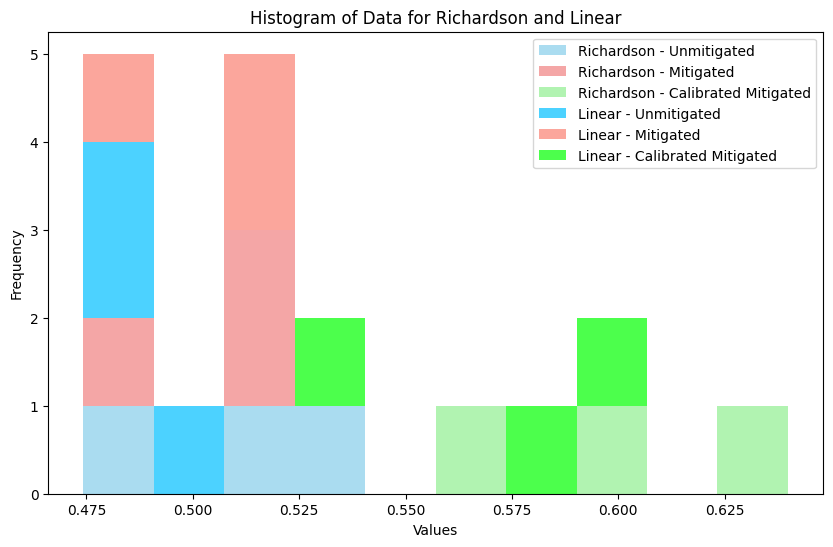

In [113]:
import matplotlib.pyplot as plt

# Provided data
data_richardson_unmitigated = [0.53125, 0.50977, 0.48242]
data_richardson_mitigated = [0.48437, 0.51953, 0.50977]
data_richardson_calibrated_mitigated = [0.60449, 0.63989, 0.56177]

data_linear_unmitigated = [0.48828, 0.48438, 0.50391]
data_linear_mitigated = [0.51921, 0.51139, 0.47428]
data_linear_calibrated_mitigated = [0.53247, 0.58228, 0.59668]

# Create the histogram with different colors for each category
plt.figure(figsize=(10, 6))
plt.hist([data_richardson_unmitigated, data_richardson_mitigated, data_richardson_calibrated_mitigated,
          data_linear_unmitigated, data_linear_mitigated, data_linear_calibrated_mitigated],
         bins=10, label=['Richardson - Unmitigated', 'Richardson - Mitigated', 'Richardson - Calibrated Mitigated',
                         'Linear - Unmitigated', 'Linear - Mitigated', 'Linear - Calibrated Mitigated'],
         color=['skyblue', 'lightcoral', 'lightgreen', 'deepskyblue', 'salmon', 'lime'], alpha=0.7, stacked=True)

# Add plot details
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Data for Richardson and Linear')
plt.legend()

# Show the plot
plt.show()


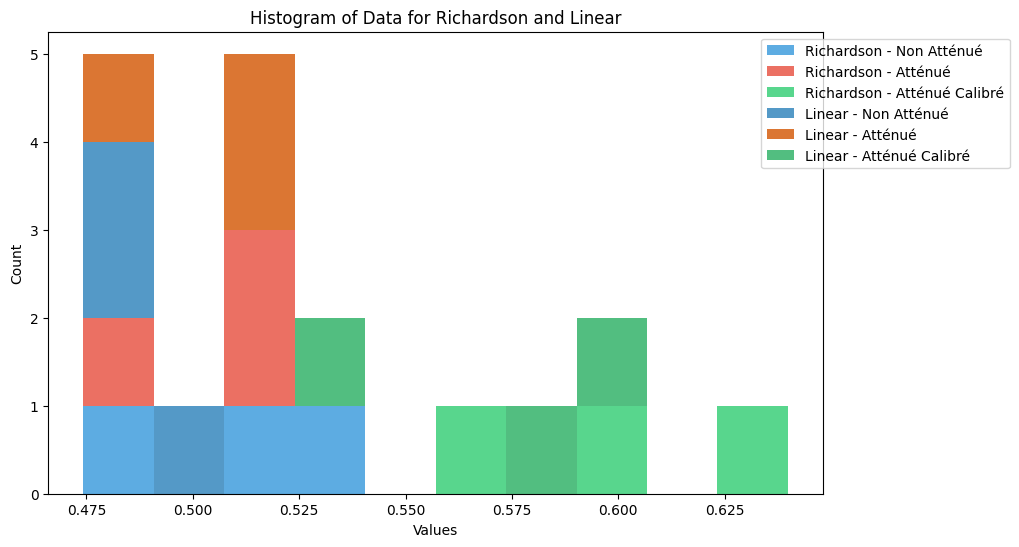

In [116]:
import matplotlib.pyplot as plt

# Données fournies
data_richardson_unmitigated = [0.53125, 0.50977, 0.48242]
data_richardson_mitigated = [0.48437, 0.51953, 0.50977]
data_richardson_calibrated_mitigated = [0.60449, 0.63989, 0.56177]

data_linear_unmitigated = [0.48828, 0.48438, 0.50391]
data_linear_mitigated = [0.51921, 0.51139, 0.47428]
data_linear_calibrated_mitigated = [0.53247, 0.58228, 0.59668]

# Création de l'histogramme avec quelques ajustements
plt.figure(figsize=(10, 6))
plt.hist([data_richardson_unmitigated, data_richardson_mitigated, data_richardson_calibrated_mitigated,
          data_linear_unmitigated, data_linear_mitigated, data_linear_calibrated_mitigated],
         bins=10, label=['Richardson - Non Atténué', 'Richardson - Atténué', 'Richardson - Atténué Calibré',
                         'Linear - Non Atténué', 'Linear - Atténué', 'Linear - Atténué Calibré'],
         color=['#3498db', '#e74c3c', '#2ecc71', '#2980b9', '#d35400', '#27ae60'], alpha=0.8, stacked=True)

# Ajout des détails du graphique
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Histogram of Data for Richardson and Linear')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

# Affichage du graphique
plt.show()


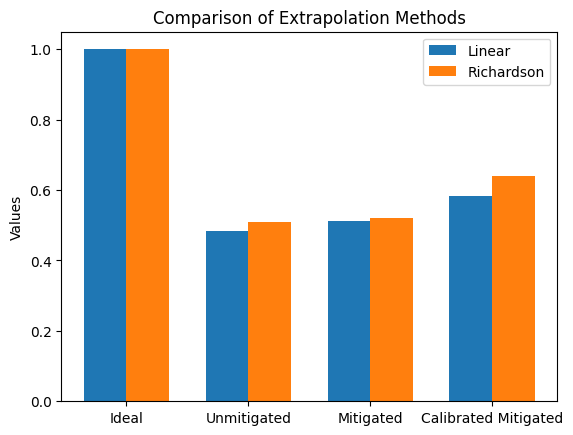

In [118]:
import matplotlib.pyplot as plt

# Data for Linear extrapolation method
deal_linear = 1
unmitigated_linear = 0.48438
mitigated_linear = 0.51139
calibrated_mitigated_linear = 0.58228

# Data for Richardson extrapolation method
ideal_richardson = 1
unmitigated_richardson = 0.50977
mitigated_richardson = 0.51953
calibrated_mitigated_richardson = 0.63989

# Labels for the bars in the histogram
labels = ['Ideal', 'Unmitigated', 'Mitigated', 'Calibrated Mitigated']

# Values for Linear extrapolation method
values_linear = [deal_linear, unmitigated_linear, mitigated_linear, calibrated_mitigated_linear]

# Values for Richardson extrapolation method
values_richardson = [ideal_richardson, unmitigated_richardson, mitigated_richardson, calibrated_mitigated_richardson]

# Create the histogram
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar([i - width/2 for i in range(len(labels))], values_linear, width, label='Linear')
rects2 = ax.bar([i + width/2 for i in range(len(labels))], values_richardson, width, label='Richardson')

# Add labels, title, and legend
ax.set_ylabel('Values')
ax.set_title('Comparison of Extrapolation Methods')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.legend()

# Display the histogram
plt.show()

